In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from datetime import datetime, timedelta

from setup.univ_setup import *
from setup.utils import *
from factor_mining.combine_factors import *
from factor_mining.factor_preprocessing import *
from performance_analysis.pa_core import *

from backtest.BackTestSinglePeriod import *
from backtest.BackTest import *
from backtest.percentile_portfolio import *

warnings.filterwarnings("ignore")

In [2]:
### universe setup ###
datadir = '/home/derek-qi/Documents/R3000_Data/data/r3000/'
univ = univ_setup(datadir, silent=False)
filt_na(univ)

Setup R3000 universe
use existing binary file
0.442810 seconds


In [3]:
from factor_mining.factors.momentum import momentum
from factor_mining.factors.momentum_gap import momentum_gap
from factor_mining.factors.revised_momentum import revised_momentum

In [27]:
%%time
# construct all variants
univ_table = stack(univ)
# univ_table.date = pd.to_datetime(univ_table.date)

head, tail = 4, 52
factors = {}
# factors['momentum'] = momentum(univ_table, head, tail)
factors['momentum'] = momentum(univ_table, head, tail)
factors['revised_momentum'] = revised_momentum(univ_table, head, tail)
factors['momentum_gap'] = momentum_gap(univ_table, head, tail, q1=0.75, q2=0.25)

CPU times: user 52.1 s, sys: 32 ms, total: 52.2 s
Wall time: 52.2 s


In [28]:
factor_names = list(factors.keys())

# concat into factor exposure matrices
factor_exp_mat = combine_factors(factors)
filt_na(factor_exp_mat)

### Filt the illiquid names within universe ###
print('Filt the untradables')

filt_byval(univ, 'in_r3000', 0)
filt_byval(univ, 'not_in_MA', 0)
filt_byval(univ, 'price', 10)
filt_byval(univ, 'volume', 1500000)
factor_exp_mat = merge(factor_exp_mat, univ, right_cols=['f_log_ret_1', 'industry'])

# Preprocessing factor expsure matrices
print('Scale each factor')
factor_exp_mat = process_batch(factor_exp_mat, standardize, factor_names=factor_names)
print('Winsorize with +/- 3 std')
factor_exp_mat = process_batch(factor_exp_mat, winsorize_std, factor_names=factor_names)
print('Done')

Filt the untradables
Scale each factor
Winsorize with +/- 3 std
Done


In [6]:
datelst = sorted(univ.keys())
print(datelst[0], datelst[-1])
start_date = datetime(2012, 1, 1)
end_date = datetime(2016, 12, 31)

2010-04-30 00:00:00 2017-04-28 00:00:00


In [29]:
spcalc = PercentilePtflSpcalc(signal='momentum', sel_range=[90, 100])
bt = BackTest(univ, factor_exp_mat, daterange, spcalc)
ptfl_lst, pnl_lst = bt.calc_pnl()

In [30]:
bt.calc_pa()

CAGR :	 0.114164859701
Volatility :	 0.162239248714
Sharpe :	 0.666331484969
Max_Drawdown :	 0.253717486688
Drawdown_Length :	 0


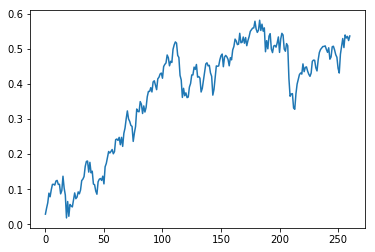

In [31]:
plt.plot(np.cumsum(pnl_lst.pnl))
plt.show()

In [12]:
spcalc = PercentilePtflSpcalc(signal='revised_momentum', sel_range=[90, 100])
bt = BackTest(univ, factor_exp_mat, daterange, spcalc)
ptfl_lst, pnl_lst = bt.calc_pnl()

In [13]:
bt.calc_pa()

CAGR :	 0.109432995112
Volatility :	 0.151270503119
Sharpe :	 0.686512356724
Max_Drawdown :	 0.249934940822
Drawdown_Length :	 0


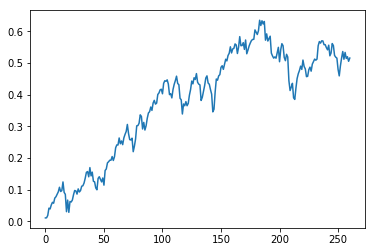

In [14]:
plt.plot(np.cumsum(pnl_lst.pnl))
plt.show()

In [21]:
spcalc = PercentilePtflSpcalc(signal='momentum_gap', sel_range=[0, 10])
bt = BackTest(univ, factor_exp_mat, daterange, spcalc)
ptfl_lst, pnl_lst = bt.calc_pnl()

In [22]:
bt.calc_pa()

CAGR :	 0.118893053042
Volatility :	 0.10121521731
Sharpe :	 1.10991068397
Max_Drawdown :	 0.113274675786
Drawdown_Length :	 0


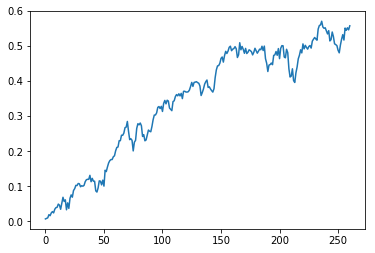

In [23]:
plt.plot(np.cumsum(pnl_lst.pnl))
plt.show()

In [9]:
%%time
from itertools import product
step = 5
ranges = [[i * step, (i + 1) * step] for i in range(100//step)]
daterange = [start_date, end_date]
config_iter = product(factor_names, ranges)
iter_result = {}
for f, g in config_iter:
    print(f,g)
    spcalc = PercentilePtflSpcalc(signal=f, sel_range=g, weighting='equal')
    bt = BackTest(univ, factor_exp_mat, daterange, spcalc)
    ptfl_lst, pnl_lst = bt.calc_pnl()
    k = f + '_' + str(g[0]) + '_' + str(g[1])
    iter_result[k] = (np.nanmean(pnl_lst.pnl), np.sqrt(np.nanvar(pnl_lst.pnl)))

revised_momentum [0, 5]
revised_momentum [5, 10]
revised_momentum [10, 15]
revised_momentum [15, 20]
revised_momentum [20, 25]
revised_momentum [25, 30]
revised_momentum [30, 35]
revised_momentum [35, 40]
revised_momentum [40, 45]
revised_momentum [45, 50]
revised_momentum [50, 55]
revised_momentum [55, 60]
revised_momentum [60, 65]
revised_momentum [65, 70]
revised_momentum [70, 75]
revised_momentum [75, 80]
revised_momentum [80, 85]
revised_momentum [85, 90]
revised_momentum [90, 95]
revised_momentum [95, 100]
momentum_gap [0, 5]
momentum_gap [5, 10]
momentum_gap [10, 15]
momentum_gap [15, 20]
momentum_gap [20, 25]
momentum_gap [25, 30]
momentum_gap [30, 35]
momentum_gap [35, 40]
momentum_gap [40, 45]
momentum_gap [45, 50]
momentum_gap [50, 55]
momentum_gap [55, 60]
momentum_gap [60, 65]
momentum_gap [65, 70]
momentum_gap [70, 75]
momentum_gap [75, 80]
momentum_gap [80, 85]
momentum_gap [85, 90]
momentum_gap [90, 95]
momentum_gap [95, 100]
momentum [0, 5]
momentum [5, 10]
momentum [1

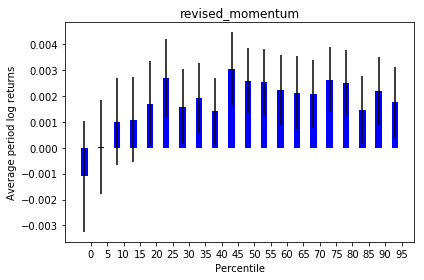

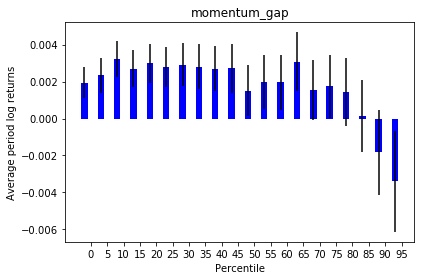

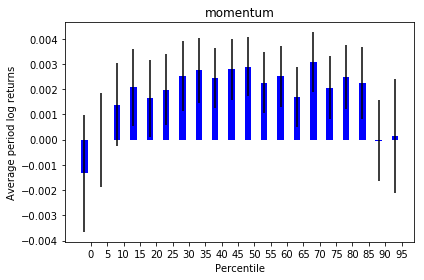

In [11]:
for n in factor_names:
    c = len(pnl_lst)
    x = [5*i for i in range(20)]
    y = [iter_result[n+'_'+str(i)+'_'+str(i+5)][0] for i in x]
    s = [iter_result[n+'_'+str(i)+'_'+str(i+5)][1] / np.sqrt(c) for i in x]
    
    # Here comes the plots
    bar_width = 2
    week = plt.bar(np.array(x), y, width=bar_width, yerr=s, color='b')

    plt.xlabel('Percentile')
    plt.ylabel('Average period log returns')
    plt.title(n)
    plt.xticks(np.array(x) + bar_width, x)
    plt.legend()

    plt.tight_layout()
    plt.show()